In [ ]:
from google.colab import drive
drive.mount('/content/drive')

default_path = "/content/drive/MyDrive/PaKoML/IDOLGAN/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import glob
img_list = []
for filename in glob.glob('/content/drive/MyDrive/PaKoML/IDOLGAN/model/archive/HQ_512x512/HQ_512x512/*.jpg'):
  im = Image.open(filename)
  img_list.append(im)
  if(len(img_list) % 1000 == 0) :
    print(f"{len(img_list)} images are loaded..");
  
print('image load done!')

1000 images are loaded..
2000 images are loaded..
3000 images are loaded..
4000 images are loaded..
5000 images are loaded..
image load done!


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import os

In [ ]:
batch_size = 1;
bn_params = 10;

In [ ]:
transforms_data = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    #transforms.Normalize([0.5],[0.5])
])

In [ ]:
class CustomDataset(Dataset) :
  def __init__(self, image_list, transform=None) :
    self.img_list = image_list;
    self.transform = transform
    
  def __len__(self) :
    return len(self.img_list); 

  def __getitem__(self, idx) :
    x_data = self.transform(img_list[idx])
    return x_data;
    

dataset = CustomDataset(img_list, transforms_data)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
latent_dim = 1000

class Generator(nn.Module) :
  def __init__(self) :
    super(Generator, self).__init__();

    self.setsize = nn.Sequential(
        nn.Linear(in_features = latent_dim, out_features=256*256*3),
    )

    self.model = nn.Sequential(
        

        nn.Conv2d(3,64,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(64,64,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),

        nn.Conv2d(64,128,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(128,128,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),

        nn.Conv2d(128,256,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(256,256,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(256,256,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),

        nn.Conv2d(256,512,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(512,512,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(512,512,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),

        nn.ConvTranspose2d(512,256,3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(256,128,3, stride = 2, padding = 0),
        nn.ReLU(),
        nn.ConvTranspose2d(128,64,3, stride = 2, padding = 0),
        nn.ReLU(),
        nn.ConvTranspose2d(64,3,3, stride = 2, padding = 0),
        nn.ReLU(),

        nn.Conv2d(3,3,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(3,3,3, stride = 1, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(3,3,3, stride = 1, padding = 'same'),
        nn.ReLU(),

    )

  def forward(self, z) :
    x_g = self.setsize(z);
    x_g = x_g.view(batch_size,3,256,256)
    x_g = self.model(x_g);
    return x_g;


In [ ]:
class Discriminator(nn.Module) :
  def __init__(self) :
    super(Discriminator, self).__init__();
    self.model = nn.Sequential(
        nn.Conv2d(3,10,3, stride =1 , padding='same'),
        nn.ReLU(),
        # nn.Conv2d(64,64,3, stride =1 , padding='same'),
        # nn.ReLU(),
        # nn.Conv2d(64,64,3, stride =1 , padding='same'),
        # nn.ReLU(),
        # nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 'same'),

        # nn.Conv2d(64,64,3, stride =1 , padding='same'),
        # nn.ReLU(),
        # nn.Conv2d(64,64,3, stride =1 , padding='same'),
        # nn.ReLU(),
        nn.Conv2d(10,3,3, stride =2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Flatten(),
        nn.Linear(in_features = 11907, out_features=300),
        nn.ReLU(),
        nn.Linear(in_features = 300, out_features=100),
        nn.ReLU(),
        nn.Linear(in_features = 100, out_features=1),
        nn.Sigmoid()
    )

  def forward (self, x) :
    p = self.model(x);
    return p;


torch.Size([1, 3, 256, 256])


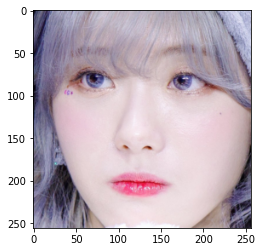

In [ ]:
imgs = next(iter(dataloader))
plt.imshow(  imgs.squeeze().permute(1, 2, 0)  )
print(np.shape(imgs))

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# Loss function
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 2e-5

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr*10, betas = (0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

In [ ]:
#When you wanna load model parameters

generator.load_state_dict(torch.load(os.path.join(default_path, 'model/generator.pt')))
generator.eval()

discriminator.load_state_dict(torch.load(os.path.join(default_path, 'model/discriminator.pt')))
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(10, 3, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=11907, out_features=300, bias=True)
    (7): ReLU()
    (8): Linear(in_features=300, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [ ]:
import time


n_epochs = 300
sample_interval = 500
start_time = time.time()

for epoch in range(n_epochs) :
  if(epoch % 5 == 0) :
    torch.save(generator.state_dict(), os.path.join(default_path, 'model/generator.pt'))
    torch.save(discriminator.state_dict(), os.path.join(default_path, 'model/discriminator.pt'))
  for i , imgs in enumerate(dataloader) :

    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

    real_imgs = imgs.cuda()

    # learn generator
    optimizer_G.zero_grad()

    z = torch.normal(mean=0, std=1, size=(batch_size, latent_dim)).cuda()
    
    generated_imgs = generator(z)


    g_loss = adversarial_loss(discriminator(generated_imgs),real)

    g_loss.backward()
    optimizer_G.step()

    # learn discriminator
    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs),real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()),fake)
    d_loss = (real_loss + fake_loss)/2;

    d_loss.backward()
    optimizer_D.step()

    done = epoch * len(dataloader) + i

    if(done % sample_interval == 0) :
      save_image(generated_imgs[:1], os.path.join(default_path, f"model/result/{done}.png"))
    
  print(f"[Epoch {epoch}/{n_epochs}] D loss : {d_loss.item():.6f}] [G loss : {g_loss.item():.6f}] [Elapsed time : {time.time() - start_time:.2f}s]")

[Epoch 0/300] D loss : 0.000020] [G loss : 100.000000] [Elapsed time : 658.20s]
[Epoch 1/300] D loss : 0.000000] [G loss : 100.000000] [Elapsed time : 1303.18s]
[Epoch 2/300] D loss : 0.000000] [G loss : 100.000000] [Elapsed time : 1948.54s]
